# Imports

In [1]:
# %pip install numpy
# %pip install opencv-python
# %pip install matplotlib
# %pip install pandas
# %pip install -U scikit-learn

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import collections
from scipy.stats import linregress
import math
from PIL import Image, ImageTransform
from matplotlib import cm
from itertools import combinations
from enum import Enum
import torch
import torchvision

# Create objects

In [3]:
universal_pieces = []

In [4]:
class Pieces:
    piece_image_color = []
    piece_image_bw = []
    corners = []
    edges = []
    corner = 0
    border = 0
    flat1 = -1
    flat2 = -1
    right = -1
    left = -1
    top = -1
    used =0
    finaltop = -1
    finalbottom = -1
    finalright = -1
    finalleft = -1

In [5]:
class Edges:
    edge_image_color = []
    edge_image_bw = []
    shape = -1
    arr = []
    high = []
    low = []

In [6]:
class Shape(Enum):
    Hole = 0
    Head = 1
    Flat = 2

# defines

In [7]:
def show(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input)
    plt.show()

def show_multiple(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

def show_gray(img_input, name):
    plt.figure(figsize = (15,15))
    # plt.axis("off")
    plt.title(name)
    plt.imshow(img_input, cmap='gray')
    plt.show()

def show_multiple_gray(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i], cmap='gray')
    plt.tight_layout()
    plt.show()

def show_multiple_mix(img_input, names, gray):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        if(gray[i]):
            plt.imshow(img_input[i], cmap='gray')
        else:
            plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

In [8]:
def do_overlap(l1, r1, l2, r2):
    # If one rectangle is on left side of other
    if l1[0] > r2[0] or l2[0] > r1[0]:
        return False
 
    # If one rectangle is above other
    if r1[1] < l2[1] or r2[1] < l1[1]:
        return False
 
    return True

In [9]:
def find_rmse(X,Y,m, c, n):
    rmse = 0
    for i in range(n):
        a = m
        b = -1
        d = abs((a * X[i] + b * Y[i] + c)) / (math.sqrt(a * a + b * b))
        rmse += d
        # y_pred = c + m * X[i]
        # rmse += (Y[i] - y_pred) ** 2
    rmse =(rmse/n)
    return rmse

In [10]:
def find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half):
    # slope1, yinter1= np.polyfit(array_line1_x, array_line1_y, 1)
    # slope2, yinter2= np.polyfit(array_line2_x, array_line2_y, 1)
    line1reg = linregress(array_line1_x, array_line1_y)
    line2reg = linregress(array_line2_x, array_line2_y)
    slope1 = line1reg.slope
    slope2 = line2reg.slope
    yinter1 = line1reg.intercept
    yinter2 = line2reg.intercept
    PI = 3.14159265
    taninv = abs((slope2 - slope1) / (1 + slope1 * slope2))
    ret = math.atan(taninv)
    angle = (ret * 180) / PI
    val=0
    if(angle>60 and angle<150):
        val = 150
    else:
        val =0
    rsme = find_rmse(array_line1_x, array_line1_y, slope1, yinter1, half) +find_rmse(array_line2_x, array_line2_y, slope2, yinter2, half)
    # rsme = line1reg.stderr + line2reg.stderr
    if(rsme>(8)):
        val = 0
    return val, rsme

In [11]:
def find_biggestsquare(list_elements):
    big_area=0
    arr=[]
    comb = combinations(list_elements, 4)
    for i, j, k, l in list(comb):
        first = i[0]*j[1] + j[0]*k[1] + k[0]*l[1] + l[0]*i[1]
        second = j[0]*i[1] + k[0]*j[1] + l[0]*k[1] + i[0]*l[1]
        area = 0.5*(first - second)
        area = abs(area)
        if(area>big_area):
            big_area = area
            arr.clear()
            arr.append(i)
            arr.append(j)
            arr.append(k)
            arr.append(l)
    
    return arr
                        

In [12]:
def add_elem(xval, yval,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half,buffer, buffer_x, buffer_y, pointer_buffer):
    array_line2_x[pointer_line2] = xval
    array_line2_y[pointer_line2] = yval
    pointer_line2 = (pointer_line2+1)%half
    array_line2_x[pointer_line2] = array_line2_x[pointer_line2]+0.001

    buffer_x[pointer_buffer] = array_line2_x[pointer_line2]
    buffer_y[pointer_buffer] = array_line2_y[pointer_line2]
    pointer_buffer = (pointer_buffer+1)%(buffer*2)

    array_line1_x[pointer_line1] = buffer_x[pointer_buffer]
    array_line1_y[pointer_line1] = buffer_y[pointer_buffer]
    pointer_line1 = (pointer_line1+1)%half
    array_line1_x[pointer_line1] = array_line1_x[pointer_line1]+0.001
    return pointer_line1, pointer_line2, pointer_buffer

In [13]:
def find_corners(find_corner_image):
    completed = False
    pieces_drawbound = np.copy(find_corner_image)

    i=0
    j=0

    while(pieces_drawbound[i+1][j+1]!=255):
        i=i+1
        j=j+1

    # pieces_drawbound[i][j] = 200
    # show_gray(pieces_drawbound,"")
    
    size = len(pieces_drawbound)/2
    buffer = 3
    half = ((int)((size+1)/2))-buffer
    array_line1_x = [0 for element in range(half)]
    array_line1_y = [0 for element in range(half)]
    pointer_line1 = 0
    buffer_x = [0 for element in range(buffer*2)]
    buffer_y = [0 for element in range(buffer*2)]
    pointer_buffer = 0
    array_line2_x = [1 for element in range(half)]
    array_line2_y = [1 for element in range(half)]
    pointer_line2 = 0

    list_elements = []

    direction =0 #0 is up, 1 is right, 2 is down and 3 is left
    move = [[-1,0],[0,1],[1,0],[0,-1]]
    initial_i = i
    initial_j = j
    counter = 0
    counter_add = 0
    while (not(completed) and counter<5000):
        counter= counter+1
        index = direction
        top_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        index = index +1
        right_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        if(right_piece==255):
            if(top_piece==255):
                direction = direction-1
            else:
                pointer_line1,pointer_line2,pointer_buffer = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half,buffer, buffer_x, buffer_y, pointer_buffer)
                counter_add = counter_add+1

                if(counter_add==(((int)((size+1)/2))-1)):
                    initial_i = i
                    initial_j = j
            
                
                if(counter_add>=size):
                    val, rsme = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                    if(val>0):
                        list_elements.append([int(buffer_x[(pointer_buffer+buffer)%(2*buffer)]),int(buffer_y[(pointer_buffer+buffer)%(2*buffer)]), rsme])
                    # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                    if(int(buffer_x[(pointer_buffer+buffer)%(2*buffer)])==initial_i and int(buffer_y[(pointer_buffer+buffer)%(2*buffer)])==initial_j):
                        completed = True

                

                i = i+move[direction%4][0]
                j = j+move[direction%4][1]
        else:
            pointer_line1,pointer_line2,pointer_buffer = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half,buffer, buffer_x, buffer_y, pointer_buffer)
            
            counter_add = counter_add+1
        
            if(counter_add==(((int)((size+1)/2))-1)):
                initial_i = i
                initial_j = j

            if(counter_add>=size):
                val, rmse = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                if(val>0):
                    list_elements.append([int(buffer_x[(pointer_buffer+buffer)%(2*buffer)]),int(buffer_y[(pointer_buffer+buffer)%(2*buffer)]), rmse])
                # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                if(int(buffer_x[(pointer_buffer+buffer)%(2*buffer)])==initial_i and int(buffer_y[(pointer_buffer+buffer)%(2*buffer)])==initial_j):
                    completed = True


            direction = direction+1
            i = i+move[direction%4][0]
            j = j+move[direction%4][1]
    # final = find_biggestsquare(list_elements)
    # print(len(list_elements))
    final_list = []
    local_min = list_elements[0][2]
    local_x = list_elements[0][0]
    local_y = list_elements[0][1]
    # final_list = list_elements
    for i in range(1,len(list_elements)):
        # print(list_elements[i])
        x = list_elements[i][0]
        y = list_elements[i][1]
        prev_x = list_elements[i-1][0]
        prev_y = list_elements[i-1][1]
        if((x>prev_x-2 and x<prev_x+2) and (y>prev_y-2 and y<prev_y+2)):
            if(list_elements[i][2]<local_min):
                local_min = list_elements[i][2]
                local_x = x
                local_y = y
        else:
            final_list.append([local_x, local_y, local_min])
            # print("hi")
            local_min = list_elements[i][2]
            local_x = x
            local_y = y
    final_list.append([local_x, local_y, local_min])
    print(len(final_list))


    final = find_biggestsquare(final_list)

    for i in final:
        cv2.circle(pieces_drawbound, (int(i[1]) , int(i[0])), 2, (200),2)
        # pieces_drawbound[int(i[0])][int(i[1])]=150


    # for i in final:
        # pieces_drawbound[i[0]][i[1]]=150
    return pieces_drawbound, [(i[0], i[1]) for i in final]


In [14]:
def combine(hole, head):
    bw_hole = hole.edge_image_bw
    color_hole = hole.edge_image_color
    bw_head = head.edge_image_bw
    color_head = head.edge_image_color
    combined = cv2.cvtColor(cv2.bitwise_xor(bw_hole, bw_head), cv2.COLOR_GRAY2RGB)
    combined = cv2.bitwise_and(combined, cv2.bitwise_or(color_hole, color_head))
    combined = cv2.bitwise_or(combined, color_hole)
    return combined, inference(combined)

In [15]:
def get_slope_intercept(p1, p2, p3):
    slope = 0
    if(p1[1] != p2[1]):
        slope = (p1[0] - p2[0]) / (p1[1] - p2[1])
    else:
        slope = 999
    intercept = p3[1] - slope*p3[0]
    return [slope, intercept]

In [16]:
def getrelativearr(image):
    arr = []
    image = np.copy(image)
    image = cv2.copyMakeBorder(image,1,0,0,0,cv2.BORDER_CONSTANT, value=0)
    image = cv2.copyMakeBorder(image,0,1,0,0,cv2.BORDER_CONSTANT, value=250)
    prevx = -1
    xval = 3
    yval = 0
    len, width = image.shape
    while (image[yval+1][xval]==0):
        yval = yval+1
    image[yval][xval] = 100

    direction =0 #0 is up, 1 is right, 2 is down and 3 is left
    move = [[-1,0],[0,1],[1,0],[0,-1]]
    counter = 0
    highesti = -1
    highj = -1
    lowesti = len
    lowj = len
    i = yval
    j = xval
    # print(width)
    while (j!=width-2 and counter<5000):
        counter= counter+1
        index = direction
        top_piece = image[i+move[index%4][0]][j+move[index%4][1]]
        index = index +1
        right_piece = image[i+move[index%4][0]][j+move[index%4][1]]
        if(right_piece==250):
            if(top_piece==250):
                direction = direction-1
            else:
                if(i>highesti):
                    highesti = i
                    highj = j
                if(i<lowesti):
                    lowesti = i
                    lowj = j
                prevx = i
                i = i+move[direction%4][0]
                j = j+move[direction%4][1]
                arr.append((prevx-i))
                image[i][j]=100
        else:
            prevx = i
            direction = direction+1
            i = i+move[direction%4][0]
            j = j+move[direction%4][1]
            arr.append((prevx-i))
            image[i][j]=100
    
    image[highesti][highj] = 150
    image[lowesti][lowj] = 150

    # print(counter)    

    # show_gray(image, "")
    return arr, [highesti, highj] , [lowesti, lowj]

In [17]:
def find_bordermatch(current_piece):
    next_piece = -1
    max = -1
    maximg = -1
    universal_pieces[current_piece].used = 1
    for i in range(len(universal_pieces)):
        if(universal_pieces[i].used ==0 and (universal_pieces[i].border == 1 or universal_pieces[i].corner == 1)):
            if(universal_pieces[current_piece].edges[universal_pieces[current_piece].right].shape == Shape.Hole):
                if(universal_pieces[i].edges[universal_pieces[i].left].shape == Shape.Head):
                    image, score = combine(universal_pieces[current_piece].edges[universal_pieces[current_piece].right], universal_pieces[i].edges[universal_pieces[i].left])
                    if(score>max):
                        max = score
                        maximg = image
                        next_piece = i
            if(universal_pieces[current_piece].edges[universal_pieces[current_piece].right].shape == Shape.Head):
                if(universal_pieces[i].edges[universal_pieces[i].left].shape == Shape.Hole):
                    image, score = combine(universal_pieces[i].edges[universal_pieces[i].left],universal_pieces[current_piece].edges[universal_pieces[current_piece].right])
                    if(score>max):
                        max = score
                        maximg = image
                        next_piece = i
    return next_piece

In [18]:
def center_match(edge1, edge2):
    if((edge1.shape == Shape.Head and edge2.shape == Shape.Hole) or (edge1.shape == Shape.Hole and edge2.shape == Shape.Head)):
        image, score = combine(edge1, edge2)
        return True, score
    return False, 0

In [19]:
def rotateDown(piece, edgeIndex):
    BOTTOM, LEFT, TOP, RIGHT = range(4)
    THRESH = 15
    side = None
    x = [corner[0] for corner in piece.corners]
    y = [corner[1] for corner in piece.corners]
    EDGECORNER = [piece.corners[edgeIndex], piece.corners[(edgeIndex+1)%4]]
    if abs(EDGECORNER[0][0] - EDGECORNER[1][0]) < THRESH:
        if abs(np.max(x) - EDGECORNER[0][0]) < THRESH:
            side = BOTTOM
        else: 
            side = TOP
    else:
        if abs(np.max(y) - EDGECORNER[0][1]) < THRESH:
            side = RIGHT 
        else: 
            side = LEFT
    image = piece.piece_image_color
    image = np.rot90(image, side)
    return image

In [20]:
def findheightwidth(pieceofuniversalarr):
    p1 = pieceofuniversalarr.corners[pieceofuniversalarr.finaltop]
    p2 = pieceofuniversalarr.corners[(pieceofuniversalarr.finaltop+1)%4]
    p3 = pieceofuniversalarr.corners[(pieceofuniversalarr.finaltop+2)%4]
    p4 = pieceofuniversalarr.corners[(pieceofuniversalarr.finaltop+3)%4]
    x,y,_ = (pieceofuniversalarr.piece_image_color).shape
    # print(x,y)
    uppad = -1
    bottompad = -1
    rightpad = -1
    leftpad = -1
    piecehigh = -1
    piecewid = -1
    if(abs(p1[0]-p2[0])>abs(p1[1]-p2[1])):
        currentwid = x
        currenthigh = y
        piecehigh = int((abs(p1[1]-p4[1])+abs(p2[1]-p3[1]))/2)
        piecewid = int((abs(p1[0]-p2[0])+abs(p3[0]-p4[0]))/2)
        
        if(p1[1]>p4[1]):
            #p4     p1
            #   ->
            #p3     p2
            #top faces right side
            leftpad = int((p1[0]+p4[0])/2)
            rightpad = currentwid - piecewid - leftpad
            bottompad = int((p4[1]+p3[1])/2)
            uppad = currenthigh - piecehigh - bottompad

        else:
            #p2     p3
            #   <- 
            #p1     p4
            #top faces left
            rightpad = int((p2[0]+p3[0])/2)
            leftpad = currentwid - piecewid - rightpad
            uppad = int((p1[1]+p2[1])/2)
            bottompad = currenthigh - piecehigh - uppad



        # print("horizontal")
    else:
        currentwid = y
        currenthigh = x
        piecehigh = int((abs(p1[0]-p4[0])+abs(p2[0]-p3[0]))/2)
        piecewid = int((abs(p1[1]-p2[1])+abs(p3[1]-p4[1]))/2)

        if(p1[0]>p4[0]):
            #p3     p4
            #   |
            #p2 v    p1
            #top faces down
            rightpad = int((p2[1]+p3[1])/2)
            leftpad = currentwid - piecewid - rightpad
            bottompad = int((p3[0]+p4[0])/2)
            uppad = currenthigh - piecehigh - bottompad


        else:
            #p1  ^   p2
            #    |
            #p4     p3
            #top faces up
            leftpad = int((p1[1]+p4[1])/2)
            rightpad = currentwid - piecewid - leftpad
            uppad = int((p1[0]+p2[0])/2)
            bottompad = currenthigh - piecehigh - uppad


        # print("vertical")
    # print(p1,p2,p3,p4)   
    return piecehigh, piecewid, uppad, rightpad, bottompad, leftpad 

In [21]:
def rotateDown(piece):
    edgeIndex = piece.finalbottom
    BOTTOM, LEFT, TOP, RIGHT = range(4)
    THRESH = 15
    side = None
    x = [corner[0] for corner in piece.corners]
    y = [corner[1] for corner in piece.corners]
    EDGECORNER = [piece.corners[edgeIndex], piece.corners[(edgeIndex+1)%4]]
    if abs(EDGECORNER[0][0] - EDGECORNER[1][0]) < THRESH:
        if abs(np.max(x) - EDGECORNER[0][0]) < THRESH:
            side = BOTTOM
        else: 
            side = TOP
    else:
        if abs(np.max(y) - EDGECORNER[0][1]) < THRESH:
            side = RIGHT 
        else: 
            side = LEFT
    image = piece.piece_image_color
    image = np.rot90(image, side)
    return image

# Load Models

In [22]:
import pickle
filename = 'relativearr/relativearr_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# prediction = loaded_model.predict(df)

In [23]:
import torchvision.models as models

model2 = torch.load('combinedarr/modelstatedict.pth')

In [24]:
import matplotlib.pyplot as plt 
device = "cuda" if torch.cuda.is_available() else "cpu"

def inference(data):
  data = cv2.resize(data, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  data = data.transpose(2,0,1)
  test_data = torch.Tensor(data)
  test_data = torchvision.transforms.functional.normalize(test_data, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  sample = torch.unsqueeze(test_data, dim=0).to(device)

  return torch.sigmoid(model2(sample))




# Read Image

In [25]:

import datetime
import time

st = datetime.datetime.now()


In [26]:

path = 'puzzle/patio16.png'
img_orig = cv2.imread(path, 1)
img_color = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

# show_multiple_mix([img_color, gray], ["Colored Puzzle", "Grayscale Puzzle"], [False, True])

In [27]:
blurred = np.copy(gray)
blurred = cv2.GaussianBlur(blurred,(21,21),0)
# show_gray(blurred,"")

In [28]:
ksize = -1 # 3
gX = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
# the gradient magnitude images are now of the floating point data
# type, so we need to take care to convert them back a to unsigned
# 8-bit integer representation so other OpenCV functions can operate
# on them and visualize them
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
# combine the gradient representations into a single image
combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
# show_gray(combined,"")

In [29]:
def detect_objects(image, image_color):
    pad =0
    universal_pieces.clear()
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,15)
    binary_image = cv2.bitwise_not(binary_image)
    # print(binary_image)

    # show_gray(binary_image,"")

    blur = cv2.GaussianBlur(image,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    mix = cv2.bitwise_or(th3, binary_image)

    # show_gray(th3, "")
    # show_gray(mix, "")
    
    kernel = np.ones((9, 9), np.uint8) 
    mix = cv2.dilate(mix, kernel, iterations=1)
    # mix = cv2.erode(mix, kernel, iterations=1)
    # mix = cv2.dilate(mix, kernel, iterations=1)
    # mix = cv2.erode(mix, kernel, iterations=1)

    # show_gray(mix, "")

    contours, _ = cv2.findContours(mix, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [list(cv2.boundingRect(x)) for x in contours]
    

    # Draw bounding boxes around each detected object
    img_with_boxes = np.copy(image)
    i=0
    while(i<len(contours)):
        contour = contours[i]
        x, y, w, h = contour
        if(w > 20 and h > 20):
            i=i+1
        else:
            del contours[i]

    # print(contours)
    i=0
    list1 = []
    while(i<len(contours)):
        contour = contours[i]
        x, y, w, h = contour
        list1.append(w*h)
        i=i+1
    
    list1, contours = zip(*sorted(zip(list1, contours)))
    contours = [list(x) for x in contours]
    contours.reverse()
    print(contours)
    i=0
    while(i<len(contours)):
        contour = contours[i]
        val = True
        x, y, w, h = contour
        xfinal = x
        yfinal = y
        x2final = w+x
        y2final = h+y
        j = i+1
        while(j<len(contours)):
            x2,y2,w2,h2 = contours[j]
            if(do_overlap([x,y],[w+x,h+y],[x2,y2],[w2+x2,h2+y2])):
                # val =False
                
                if(x2<xfinal):
                    xfinal = x2
                if(y2<yfinal):
                    yfinal = y2
                if(x2final<w2+x2):
                    x2final = w2+x2
                if(y2final<h2+y2):
                    y2final = h2+y2
                # print(contours[j])
                del contours[j]
                j=j-1
                
            j = j+1
        
        contours[i] = [xfinal, yfinal, x2final-xfinal, y2final-yfinal]
        x,y,w,h = contours[i]
        
        cv2.rectangle(img_with_boxes, (x-3, y-3), (x + w + 3, y + h + 3), (204, 204, 0), 2)
        puzzle_piece = Pieces()
        puzzle_piece.piece_image_bw = image[y-pad:y+h+pad, x-pad:x+w+pad]
        puzzle_piece.piece_image_bw = cv2.copyMakeBorder(puzzle_piece.piece_image_bw, 10,10,10,10,cv2.BORDER_CONSTANT, 0)
        puzzle_piece.piece_image_color = image_color[y-pad:y+h+pad, x-pad:x+w+pad]
        puzzle_piece.piece_image_color = cv2.copyMakeBorder(puzzle_piece.piece_image_color, 10,10,10,10,cv2.BORDER_REPLICATE, 0)
        universal_pieces.append(puzzle_piece)
        i=i+1
    return img_with_boxes

# Example usage: store pieces
image_pieces_detected = detect_objects(combined, img_color)

# Display the result
# show_gray(image_pieces_detected, "Detected Pieces")

[[2761, 16, 598, 525], [1596, 85, 550, 509], [78, 30, 436, 604], [619, 665, 589, 425], [1120, 1133, 485, 511], [1331, 659, 555, 437], [2207, 618, 398, 607], [2227, 50, 446, 521], [75, 686, 433, 525], [580, 108, 491, 441], [1734, 1119, 420, 510], [1116, 81, 399, 521], [2672, 1162, 486, 422], [2754, 589, 402, 506], [573, 1213, 436, 427], [74, 1217, 399, 423]]


In [30]:
# fig, axes = plt.subplots(nrows=len(universal_pieces), ncols=1, figsize=(150, 50))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = np.copy((universal_pieces[i]).piece_image_color)
    image = cv2.GaussianBlur(image, (15,15),0)
    ksize = -1
    gX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    gY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    # combine the gradient representations into a single image
    combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

    # image = cv2.medianBlur(combined, 15)
    image = cv2.GaussianBlur(combined, (25,25),0)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # gX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    # gY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

    # gX = cv2.convertScaleAbs(gX)
    # gY = cv2.convertScaleAbs(gY)
    # # combine the gradient representations into a single image
    # combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

    # image = cv2.cvtColor(combined, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((3, 3), np.uint8) 
    # image = cv2.dilate(image, kernel, iterations=1)
    # image = cv2.erode(image, kernel, iterations=1)
    # image = cv2.dilate(image, kernel, iterations=1)
    # image = cv2.erode(image, kernel, iterations=1)
    # image = cv2.dilate(image, kernel, iterations=1)
    # image = cv2.erode(image, kernel, iterations=1)

    image = cv2.Canny(image,0,25)
    # image = connect_nearby(image, 2)
    (universal_pieces[i]).piece_image_bw = cv2.adaptiveThreshold((universal_pieces[i]).piece_image_bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,255,-15)
    image = cv2.bitwise_or(image, (universal_pieces[i]).piece_image_bw)
    # ret3,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8) 
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.dilate(image, kernel, iterations=1)
    # print(image)

    im_floodfill = image.copy()
    im_floodfill = cv2.copyMakeBorder(im_floodfill, 1,0,0,0,cv2.BORDER_CONSTANT, 0)
    h, w = im_floodfill.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = im_floodfill_inv[1:]

    image = image | im_floodfill_inv

    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)


    # image = 
    
    # image = remove_background(image, 0.5)
    # image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,15)
    image = cv2.GaussianBlur(image, (21,21),0)
    ret3,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    (universal_pieces[i]).piece_image_bw = image
    # axes[i].imshow(image, cmap = 'gray')
    # axes[i].axis('off')  # Turn off axis labels
    # axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
# plt.tight_layout()
# plt.show()

In [31]:
# fig, axes = plt.subplots(nrows=len(universal_pieces), ncols=1, figsize=(150, 50))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_color
    mask = (universal_pieces[i]).piece_image_bw
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # print(image.shape)
    # print(mask.shape)
    image = cv2.bitwise_and(image, mask)
    (universal_pieces[i]).piece_image_color = image
#     axes[i].imshow(image)
#     axes[i].axis('off')  # Turn off axis labels
#     axes[i].set_title(f"{i+1}")
# # Adjust layout for better visualization
# plt.tight_layout()
# plt.show()

# Find corners

In [32]:
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_bw
    piece_with_corner, corners = find_corners(image)
    (universal_pieces[i]).corners  = corners
    # show_gray(piece_with_corner,"")

14
12
12
16
10
17
10
10
13
14
16
12
15
11
14
10


# Get Edge Images

In [33]:
pieces_side_points = []
colored_pieces_side_points = []

for ind in range(len(universal_pieces)):
    puzzle = (universal_pieces[ind]).corners
    sides = []
    x_avg = sum([j[1] for j in puzzle])/4
    y_avg = sum([j[0] for j in puzzle])/4
    for i in range(4):
        x_mid = (puzzle[i][1] + puzzle[(i+1)%4][1])/2
        y_mid = (puzzle[i][0] + puzzle[(i+1)%4][0])/2
        slope_intercept = get_slope_intercept(puzzle[i], puzzle[(i+1)%4], (x_mid, y_mid))
        inner_line_slope_intercept = [slope_intercept[0], y_avg - slope_intercept[0]*x_avg]
        pieces_corner_drawn = (universal_pieces[ind]).piece_image_bw
        heig, leng = pieces_corner_drawn.shape

        for x in range(leng):
            y = int(slope_intercept[0] * x + slope_intercept[1])
            while 0 <= y < heig:
                if pieces_corner_drawn[y][x] == 255:
                    if(slope_intercept[1] > inner_line_slope_intercept[1]):
                        slope_intercept[1] += 1
                    else:
                        slope_intercept[1] -= 1
                else: break
                y = int(slope_intercept[0] * x + slope_intercept[1])

        if(slope_intercept[0] != 0):
            for y in range(heig):
                x = int(((y-slope_intercept[1]) / slope_intercept[0]))
                while 0 <= x < leng:
                    if pieces_corner_drawn[y][x] == 255:
                        if(slope_intercept[1] > inner_line_slope_intercept[1]):
                            slope_intercept[1] += 1
                        else:
                            slope_intercept[1] -= 1
                    else: break
                    x = int(((y-slope_intercept[1]) / slope_intercept[0]))

        orthogonal_slope = -1/slope_intercept[0] if slope_intercept[0] != 0 else 999
        
        top_left_orthogonal_intercept = puzzle[i][0] - orthogonal_slope*puzzle[i][1]
        top_left_x = (top_left_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_left_y = orthogonal_slope*top_left_x + top_left_orthogonal_intercept
        bottom_left_x = (top_left_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_left_y = orthogonal_slope * bottom_left_x + top_left_orthogonal_intercept 

        top_right_orthogonal_intercept = puzzle[(i+1)%4][0] - orthogonal_slope*puzzle[(i+1)%4][1]
        top_right_x = (top_right_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_right_y = orthogonal_slope * top_right_x + top_right_orthogonal_intercept 
        bottom_right_x = (top_right_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_right_y = orthogonal_slope * bottom_right_x + top_right_orthogonal_intercept 

        #important part (x, y) where x is axis 1 and y is axis 0
        square = [(top_right_x, top_right_y), (bottom_right_x, bottom_right_y), (bottom_left_x, bottom_left_y), (top_left_x, top_left_y)]
        square = [(int(x), int(y)) for x, y in square]
        sides.append(square)
        def draw_line(image, slope, intercept, color=140, thickness=1):
            # Get image dimensions
            length, height= image.shape
            x1 = 0
            y1 = int(slope*x1 + intercept)
            x2 = int(height)
            y2 = int(slope*x2 + intercept)
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
        # draw_line(pieces_corner_drawn[ind], slope_intercept[0], slope_intercept[1])
        # draw_line(pieces_corner_drawn[ind], inner_line_slope_intercept[0], inner_line_slope_intercept[1])
    pieces_side_points.append(sides)
    # show_gray(pieces_corner_drawn, "")
                

In [34]:
b_w_edges = []
for num, x in enumerate(pieces_side_points):
    piece_edges = []
    for y in x:
        len1 = (int) (math.dist(y[0], y[1]))
        len2 = (int) (math.dist(y[1], y[2]))
        transform=[y[3][0], y[3][1], y[2][0], y[2][1], y[1][0], y[1][1], y[0][0], y[0][1]]
        
        img_copy = np.copy((universal_pieces[num]).piece_image_color)
        im = Image.fromarray(img_copy)
        result = im.transform((len2,len1), ImageTransform.QuadTransform(transform))
        img_copy = np.array(result)

        img_copy_bw = np.copy((universal_pieces[num]).piece_image_bw)
        img_copy_bw = img_copy_bw/255
        im = Image.fromarray(np.uint8(cm.gist_earth(img_copy_bw)*255))
        result = im.transform((len2,len1), ImageTransform.QuadTransform(transform))
        img_copy_bw = np.array(result)
        img_copy_bw = cv2.cvtColor(img_copy_bw, cv2.COLOR_BGR2GRAY)

        img_edge = Edges()
        
        img_edge.edge_image_color = img_copy
        img_edge.edge_image_bw = img_copy_bw
        piece_edges.append(img_edge)

    (universal_pieces[num]).edges = piece_edges
    




In [35]:
min_width = 1000000
max = 0
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        _, thickness = ((image[j]).edge_image_bw).shape

        edge = (image[j]).edge_image_bw
        relative, high, low  = getrelativearr(edge)
        relative = np.array(relative)

        (image[j]).high = high
        (image[j]).low = low
        (image[j]).arr = relative
        

        if(len(relative)>1222):
            relative = relative[:1222]
            relative = relative.reshape(1, -1)
        else:
            relative = relative.reshape(1, -1)
            relative = cv2.resize(relative, (1222,1), interpolation=cv2.INTER_NEAREST)
            # relative = np.pad(relative, (0, 1222-len(relative)), "constant", constant_values=0)
        
        value = loaded_model.predict(relative)
        if(value == 1):
            if(thickness<min_width):
                min_width = thickness
            width = high[0] - low[0]
            if(width>max):
                max = width
            (image[j]).shape = Shape.Head
            # print("head")
        if(value == 2):
            if(thickness<min_width):
                min_width = thickness
            width = high[0] - low[0]
            
            if(width>max):
                max = width
            (image[j]).shape = Shape.Hole
            # print("hole")
        if(value==0):
            (image[j]).shape = Shape.Flat
            # print("flat")
        # show(edge, "")

C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: 

In [36]:
# print(max)
# print(min_width)
pad = 15
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        _, edge_width = ((image[j]).edge_image_bw).shape
        start_width = int((edge_width-min_width)/2)
        end_width = edge_width-(edge_width-min_width-start_width)
        if((image[j]).shape == Shape.Head):
            (image[j]).edge_image_bw = ((image[j]).edge_image_bw)[:max,start_width:end_width]
            (image[j]).edge_image_color = ((image[j]).edge_image_color)[:max,start_width:end_width]
            # (image[j]).edge_image_bw = cv2.copyMakeBorder((image[j]).edge_image_bw,pad,0,0,0,cv2.BORDER_CONSTANT, value=0)
            # (image[j]).edge_image_color = cv2.copyMakeBorder((image[j]).edge_image_color,pad,0,0,0,cv2.BORDER_CONSTANT, value=0)
            (image[j]).edge_image_bw = np.rot90(np.rot90((image[j]).edge_image_bw))
            (image[j]).edge_image_color = np.rot90(np.rot90((image[j]).edge_image_color))
        if((image[j]).shape == Shape.Hole):
            stop = (image[j]).high[0]
            padding = max - stop
            # print(stop)
            # print(padding)
            # print(stop+padding)
            # print(max)
            start = 0
            if(padding<0):
                start = 0 - padding
                padding = 0
            (image[j]).edge_image_bw = ((image[j]).edge_image_bw)[start:(stop),start_width:end_width]
            (image[j]).edge_image_color = ((image[j]).edge_image_color)[start:(stop),start_width:end_width]
            (image[j]).edge_image_bw = cv2.copyMakeBorder((image[j]).edge_image_bw,padding,0,0,0,cv2.BORDER_CONSTANT, value=0)
            (image[j]).edge_image_color = cv2.copyMakeBorder((image[j]).edge_image_color,padding,0,0,0,cv2.BORDER_CONSTANT, value=0)
            
            


for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        if((image[j]).shape != Shape.Flat):
            edge = (image[j]).edge_image_bw
            # show_gray(edge, "")
            # print(edge.shape)

In [37]:
hole_arr = []
head_arr = []
combined_img_arr = []
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).edges
    for j in range(len(image)):
        if((image[j]).shape == Shape.Hole):
            hole_arr.append((i, j))
        elif((image[j]).shape == Shape.Head):
            head_arr.append((i, j))

for i in hole_arr:
    for j in head_arr:
        bw_hole = (universal_pieces[i[0]]).edges[i[1]].edge_image_bw
        color_hole = (universal_pieces[i[0]]).edges[i[1]].edge_image_color
        bw_head = (universal_pieces[j[0]]).edges[j[1]].edge_image_bw
        color_head = (universal_pieces[j[0]]).edges[j[1]].edge_image_color
        combined = cv2.cvtColor(cv2.bitwise_xor(bw_hole, bw_head), cv2.COLOR_GRAY2RGB)
        combined = cv2.bitwise_and(combined, cv2.bitwise_or(color_hole, color_head))
        combined = cv2.bitwise_or(combined, color_hole)
        combined_img_arr.append(combined)

# combine

In [38]:
for i in range(len(universal_pieces)):
    # show(universal_pieces[i].piece_image_color, "")


    for j in range(len(universal_pieces[i].edges)):
        if(universal_pieces[i].edges[j].shape == Shape.Flat):
            if(universal_pieces[i].edges[(j+1)%4].shape == Shape.Flat):
                universal_pieces[i].corner = 1
                universal_pieces[i].right = (j+3)%4
                universal_pieces[i].left = (j+2)%4
                universal_pieces[i].flat1 = (j+1)%4
                universal_pieces[i].flat2 = j
                # print("corner")
                break
            elif(universal_pieces[i].edges[(j+3)%4].shape == Shape.Flat):
                universal_pieces[i].corner = 1
                universal_pieces[i].right = (j+2)%4
                universal_pieces[i].left = (j+1)%4
                universal_pieces[i].flat1 = j
                universal_pieces[i].flat2 = (j+3)%4
                # print("corner")
                break
            else:
                universal_pieces[i].border = 1
                universal_pieces[i].left = (j+1)%4
                universal_pieces[i].top = (j+2)%4
                universal_pieces[i].right = (j+3)%4
                # print("flat")
                break
        # show(universal_pieces[i].edges[j].edge_image_color, "")

In [39]:
corner_index = -1
for i in range(len(universal_pieces)):
    if((universal_pieces[i]).corner == 1):
        corner_index = i
        i = len(universal_pieces)

In [40]:
rows, cols = (len(universal_pieces), len(universal_pieces))
arr = [[0 for _ in range(cols)] for _ in range(rows)]
# print(arr)
current_piece = corner_index
current_indx = 0
current_indy = 0
direction = 0 # 0 - down, 1 - right, 2 - up, 3 - left
dir_arr = [[1,0],[0,1],[-1,0],[0,-1]]
# 0,0           0,len
# 
# len,0         len,len

#step 1: find border

finaldir = [0,1,2,3]
finaldirpoint = 0

while(current_piece!=-1):
    arr[int(current_indx)][int(current_indy)] = current_piece+1
    universal_pieces[current_piece].finalbottom = (universal_pieces[current_piece].right + finaldir[finaldirpoint])%4
    universal_pieces[current_piece].finalleft = (universal_pieces[current_piece].finalbottom+1)%4
    universal_pieces[current_piece].finaltop = (universal_pieces[current_piece].finalbottom+2)%4
    universal_pieces[current_piece].finalright = (universal_pieces[current_piece].finalbottom+3)%4
    # print(current_ind, current_piece)
    # print(arr)
    # show(universal_pieces[current_piece].piece_image_color, "")
    current_piece = find_bordermatch(current_piece)
    if(current_piece!=-1):
        current_indx = current_indx+dir_arr[direction][0]
        current_indy = current_indy+dir_arr[direction][1]
    if(universal_pieces[current_piece].corner==1):
        finaldirpoint = finaldirpoint+1
        direction = (direction +1)%4
        

In [41]:
while(np.count_nonzero(arr)<len(universal_pieces)):
    if(arr[current_indx+dir_arr[direction][0]][current_indy+dir_arr[direction][1]] != 0):
        direction = (direction+1)%4
        current_indx = current_indx+dir_arr[direction][0]
        current_indy = current_indy+dir_arr[direction][1]
    else:
        current_indx = current_indx+dir_arr[direction][0]
        current_indy = current_indy+dir_arr[direction][1]
    # print(current_indx, current_indy)

    toppiece = -1
    rightpiece = -1
    leftpiece = -1
    bottompiece = -1
    if(arr[current_indx-1][current_indy] != 0):
        toppiece = universal_pieces[arr[current_indx-1][current_indy] - 1].edges[universal_pieces[arr[current_indx-1][current_indy]-1].finalbottom]
        # show(toppiece.edge_image_color, "")
    if(arr[current_indx][current_indy+1] != 0):
        rightpiece = universal_pieces[arr[current_indx][current_indy+1] - 1].edges[universal_pieces[arr[current_indx][current_indy+1]-1].finalleft]
        # show(rightpiece.edge_image_color, "")
    if(arr[current_indx][current_indy-1] != 0):
        leftpiece = universal_pieces[arr[current_indx][current_indy-1] - 1].edges[universal_pieces[arr[current_indx][current_indy-1]-1].finalright]
        # show(leftpiece.edge_image_color, "")  
    if(arr[current_indx+1][current_indy] != 0):
        bottompiece = universal_pieces[arr[current_indx+1][current_indy] - 1].edges[universal_pieces[arr[current_indx+1][current_indy]-1].finaltop]
        # show(bottompiece.edge_image_color, "")
    
    maxscore = 0
    maxscorepiece = -1
    maxscorepieceorient = -1
    for i in range(len(universal_pieces)):
        if(universal_pieces[i].used==0):
            for j in range(4):
                curtoppiece = universal_pieces[i].edges[j]
                currightpiece = universal_pieces[i].edges[(j+1)%4]
                curbottompiece = universal_pieces[i].edges[(j+2)%4]
                curleftpiece = universal_pieces[i].edges[(j+3)%4]
                count = 0
                value = 0
                isCompatible = True
                if(toppiece!=-1 and isCompatible):
                    count = count+1
                    isCompatible, score = center_match(toppiece, curtoppiece)
                    value = value + score
                if(rightpiece!=-1 and isCompatible):
                    count = count+1
                    isCompatible, score = center_match(rightpiece, currightpiece)
                    value = value + score
                if(bottompiece!=-1 and isCompatible):
                    count = count+1
                    isCompatible, score = center_match(bottompiece, curbottompiece)
                    value = value + score
                if(leftpiece!=-1 and isCompatible):
                    count = count+1
                    isCompatible, score = center_match(leftpiece, curleftpiece)
                    value = value + score
                if(isCompatible):
                    value = value/count
                    if(value>maxscore):
                        maxscore = value
                        maxscorepiece = i
                        maxscorepieceorient = j
    
    if(maxscore!=0):
        arr[current_indx][current_indy] = maxscorepiece+1
        universal_pieces[maxscorepiece].finaltop = maxscorepieceorient
        universal_pieces[maxscorepiece].finalright = (maxscorepieceorient+1)%4
        universal_pieces[maxscorepiece].finalbottom = (maxscorepieceorient+2)%4
        universal_pieces[maxscorepiece].finalleft = (maxscorepieceorient+3)%4
    else:
        arr[current_indx][current_indy] = -1


   
    
    
    


# arr

In [42]:
indexwidth = arr[0].index(0)
indexheight = int((len(universal_pieces))/indexwidth)

finalindex = []
for i in range(indexheight):
    local = []
    for j in range(indexwidth):
        local.append(arr[i][j])
    finalindex.append(local)

# print(finalindex)

In [43]:
indexright = []
for i in range(indexheight):
    local = []
    for j in range(indexwidth):
        local.append(findheightwidth(universal_pieces[finalindex[i][j]-1]))
    indexright.append(local)

In [44]:
correctimage = []
for i in range(indexheight):
    local = []
    for j in range(indexwidth):
        local.append(rotateDown(universal_pieces[finalindex[i][j]-1] , ))
    correctimage.append(local)

In [45]:
finalheight = []
for i in indexright:
    localmax = 0
    for j in i:
        # print(j[0])
        if(j[0]>localmax):
            localmax = j[0]
    finalheight.append(localmax)

In [46]:
finalwidth = []
for i in range(len(indexright[0])):
    localmax = 0
    for j in range(len(indexright)):
        if(localmax<indexright[j][i][1]):
            localmax = indexright[j][i][1]
    finalwidth.append(localmax)

In [47]:
leftpad = []
localsum = 0
leftpad.append(localsum)
for i in range(len(finalwidth)-1):
    localsum = localsum + finalwidth[i]
    leftpad.append(localsum)

In [48]:
rightpad = []
localsum = 0
rightpad.append(localsum)
for i in range(len(finalwidth)-1, 0, -1):
    localsum = localsum + finalwidth[i]
    rightpad.append(localsum)
rightpad.reverse()

In [49]:
toppad = []
localsum = 0
toppad.append(localsum)
for i in range(len(finalheight)-1):
    localsum = localsum + finalheight[i]
    toppad.append(localsum)

In [50]:
bottompad = []
localsum = 0
bottompad.append(localsum)
for i in range(len(finalheight)-1, 0, -1):
    localsum = localsum + finalheight[i]
    bottompad.append(localsum)
bottompad.reverse()

In [51]:
for i in range(len(correctimage)):
    for j in range(len(correctimage[0])):
        toppadpiece = 0
        bottompadpiece = 0
        rightpadpiece = 0
        leftpadpiece = 0

        toppadpiece = finalheight[i] - indexright[i][j][0]
        toppadpiece = int(toppadpiece/2)
        bottompadpiece = finalheight[i] - indexright[i][j][0] - toppadpiece
        toppadpiece = toppadpiece + toppad[i] - indexright[i][j][2]
        bottompadpiece = bottompadpiece + bottompad[i] - indexright[i][j][4]

        rightpadpiece = finalwidth[j] - indexright[i][j][1]
        rightpadpiece = int(rightpadpiece/2)
        leftpadpiece = finalwidth[j] - indexright[i][j][1] - rightpadpiece
        rightpadpiece = rightpadpiece + rightpad[j] - indexright[i][j][3]
        leftpadpiece = leftpadpiece + leftpad[j] - indexright[i][j][5]
        print(toppadpiece, bottompadpiece, rightpadpiece, leftpadpiece)

        if(toppadpiece>0):
            correctimage[i][j] = cv2.copyMakeBorder(correctimage[i][j], toppadpiece, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
        else:
            correctimage[i][j] = correctimage[i][j][abs(toppadpiece):]

        if(bottompadpiece>0):
            correctimage[i][j] = cv2.copyMakeBorder(correctimage[i][j], 0, bottompadpiece, 0, 0, cv2.BORDER_CONSTANT, 0)
        else:
            correctimage[i][j] = correctimage[i][j][:bottompadpiece]

        if(rightpadpiece>0):
            correctimage[i][j] = cv2.copyMakeBorder(correctimage[i][j], 0, 0, 0, rightpadpiece, cv2.BORDER_CONSTANT, 0)
        else:
            correctimage[i][j] = correctimage[i][j][:, :rightpadpiece]

        if(leftpadpiece>0):
            correctimage[i][j] = cv2.copyMakeBorder(correctimage[i][j], 0, 0, leftpadpiece, 0, cv2.BORDER_CONSTANT, 0)
        else:
            correctimage[i][j] = correctimage[i][j][:, abs(leftpadpiece):]

        # show(correctimage[i][j], "")
# print(correctimage)

-26 996 1070 -27
-30 953 698 247
-25 996 245 614
-31 914 -27 1071
212 607 988 -31
286 650 618 323
210 604 333 696
303 646 -29 985
631 302 1064 -25
555 216 695 246
627 306 243 619
556 224 -28 1069
909 -25 985 -30
996 -26 614 331
904 -26 325 700
990 -23 -26 986


In [52]:
finalperfectimage = correctimage[0][0]

for i in range(len(correctimage)):
    for j in range(len(correctimage[0])):
        finalperfectimage = cv2.bitwise_or(finalperfectimage, correctimage[i][j])

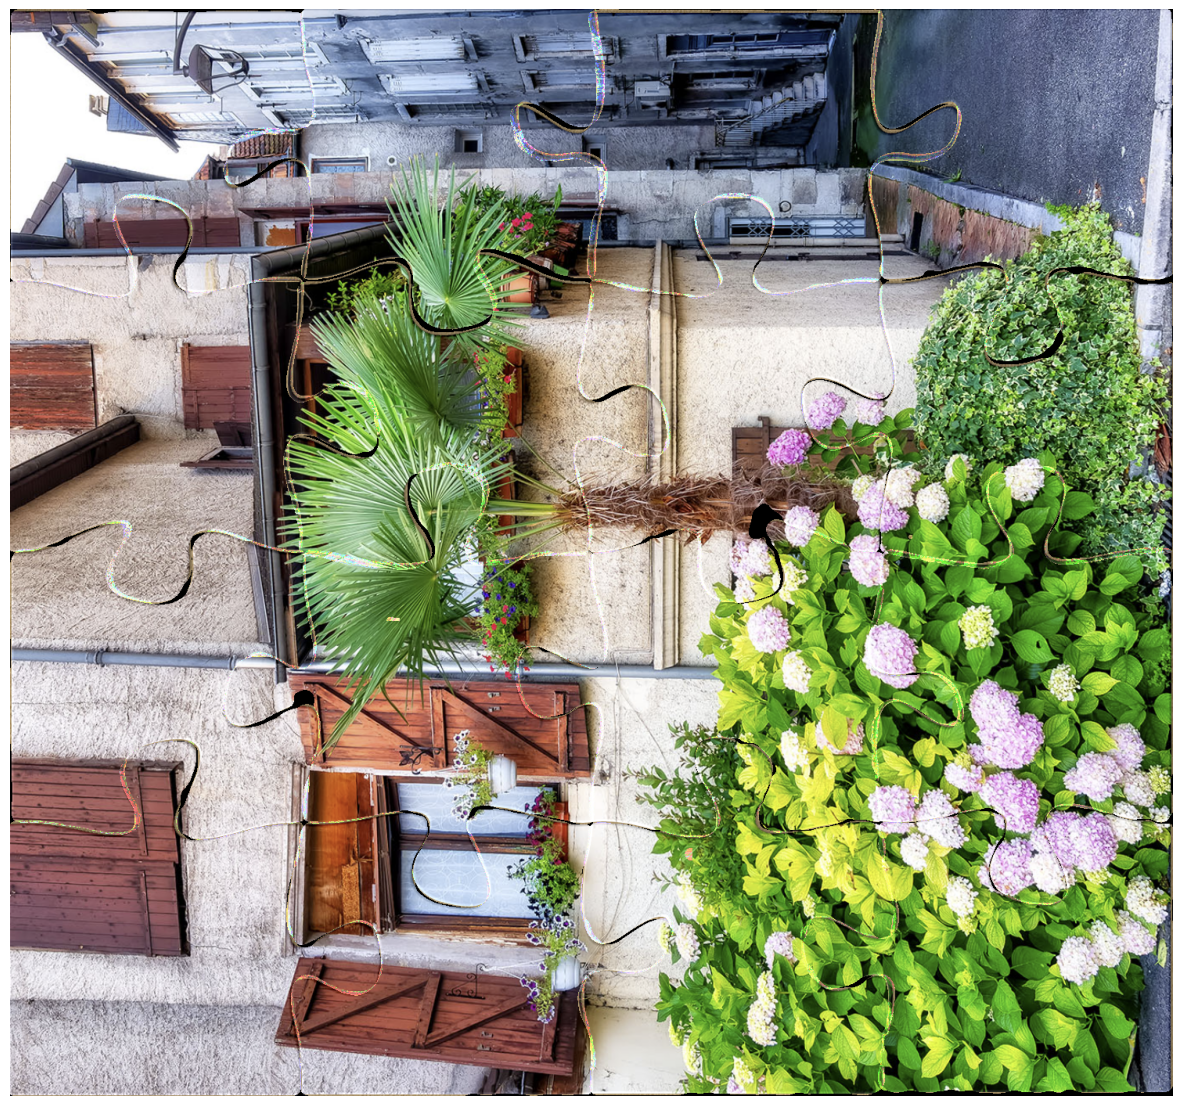

In [53]:
show(finalperfectimage, "")

In [54]:
# get the end datetime
et = datetime.datetime.now()

# get execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0:00:27.721062 seconds
